In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer#导入数据
from sklearn.model_selection import train_test_split#用于训练集和测试集的划分
from sklearn.neighbors import KNeighborsClassifier#k近邻算法
from sklearn.naive_bayes import GaussianNB#高斯朴素贝叶斯
from sklearn.tree import DecisionTreeClassifier#决策树
from sklearn.linear_model import LogisticRegression#逻辑回归
from sklearn.ensemble import RandomForestClassifier#随机森林bagging模型
from sklearn.ensemble import AdaBoostClassifier#自适应增强模型boosting模型
from sklearn.svm import LinearSVC#支持向量机
from sklearn.metrics import roc_curve#绘制roc曲线的函数
from sklearn.metrics import auc#得分
from sklearn.metrics import confusion_matrix#绘制混沌矩阵
from sklearn.preprocessing import StandardScaler#标准化

# 数据解读

In [2]:
data_all=load_breast_cancer()
data=pd.DataFrame(np.c_[data_all.data,data_all.target],columns=list(data_all.feature_names)+['类别'])
print(data_all.target_names)#0是恶行肿瘤，1是良性肿瘤
data#共30个特征，569个样本

['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,类别
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


# 数据预处理

In [3]:
data_all.target_names

array(['malignant', 'benign'], dtype='<U9')

## 判断数据有无缺失值

In [4]:
data.columns[data.isnull().sum()!=0]#判断数据是否有缺失值，并把含有缺失值的那一列print出来
#我们发现这个数据没有缺失值

Index([], dtype='object')

## 观察数据的dtype，是否需要编码处理

In [5]:
data.dtypes[data.dtypes!='float64']
#数据都是float64类型

Series([], dtype: object)

## 观察样本分类数量是否均衡
即良性肿瘤和恶行肿瘤有着相同的样本量

In [6]:
print(f'原始数据的类别分布\n{data.类别.value_counts()}')#发现不均衡
#运用下采样的方法，在种类1(良性肿瘤)中抽取212个样本，与恶性肿瘤的数量相一致
data_sample = data[data.类别==1].sample(212)#下采样的种类1的数据集
data_new=pd.concat([data_sample,data[data.类别==0]],axis=0)#整理后的新数据
print()
print(f'下采样后的类别分布\n{data_new.类别.value_counts()}')

原始数据的类别分布
1.0    357
0.0    212
Name: 类别, dtype: int64

下采样后的类别分布
0.0    212
1.0    212
Name: 类别, dtype: int64


## 对数据集进行拆分(数据集+测试集)
这里的数据集指：验证集+训练集

### 测试集的拆分

In [7]:
data_set,feature_test,data_labels,labels_test=train_test_split(data_new.iloc[:,:-1].values,
            data_new.iloc[:,-1].values,test_size=0.25,stratify=data_new.iloc[:,-1].values)#stratify控制拆分数据集时，target分布是均匀的

In [8]:
#验证下拆分后是否labels均匀
from collections import Counter
print(f'测试集种类1的数量{labels_test[labels_test==1].size}')
print(f'测试集种类0的数量{labels_test[labels_test==0].size}')
#样本分布均匀

测试集种类1的数量53
测试集种类0的数量53


### 数据集的拆分

In [9]:
feature_train,feature_cv,labels_train,labels_cv=train_test_split(data_set,
                                                                 data_labels,test_size=0.25,stratify=data_labels)

In [10]:
#验证下拆分后是否labels均匀
print(f'训练集种类1的数量{labels_train[labels_train==1].size}')
print(f'训练集种类0的数量{labels_train[labels_train==0].size}')
print()
print(f'验证集种类1的数量{labels_cv[labels_cv==1].size}')
print(f'验证集种类0的数量{labels_cv[labels_cv==0].size}')

训练集种类1的数量119
训练集种类0的数量119

验证集种类1的数量40
验证集种类0的数量40


## 对数据标准化

In [11]:
std=StandardScaler()
std.fit(feature_train,labels_train)#在训练集上拟合
feature_train_std=std.transform(feature_train)
feature_cv_std=std.transform(feature_cv)#验证集的标准化
feature_test_std=std.transform(feature_test)#测试集的标准化

# 开始建模

## 各分类器建模

引入所有模块的对象

In [12]:
model1=KNeighborsClassifier()
model2=GaussianNB()
model3=DecisionTreeClassifier(criterion='entropy',random_state=2)
model4=LogisticRegression(penalty='l2')
model5=RandomForestClassifier(n_estimators=50,criterion='gini',random_state=1)
model6=AdaBoostClassifier(n_estimators=50,random_state=1)
model7=LinearSVC(penalty='l2',tol=1e-5,random_state=1)

In [13]:
score=[]
all_model=[model1,model2,model3,model4,model5,model6,model7]
confusion_matrixs=[]
roc_score=[]
for i in range(len(all_model)):
    all_model[i].fit(feature_train,labels_train)
    pred_cv=all_model[i].predict(feature_cv)#验证集的预测
    confusion_matrixs.append(confusion_matrix(labels_cv,pred_cv))#绘制混淆矩阵
    score.append(all_model[i].score(feature_cv,labels_cv))
    if i<6:
        roc_score.append(all_model[i].predict_proba(feature_cv)[:,1])
    else:
        roc_score.append(all_model[i].decision_function(feature_cv))

In [14]:
df1=pd.DataFrame(score,index=['KNeighborsClassifier','GaussianNB','DecisionTreeClassifier','LogisticRegression','RandomForestClassifier',
                      'AdaBoostClassifier','LinearSVC'],columns=['准确度'])

## 绘制混淆矩阵

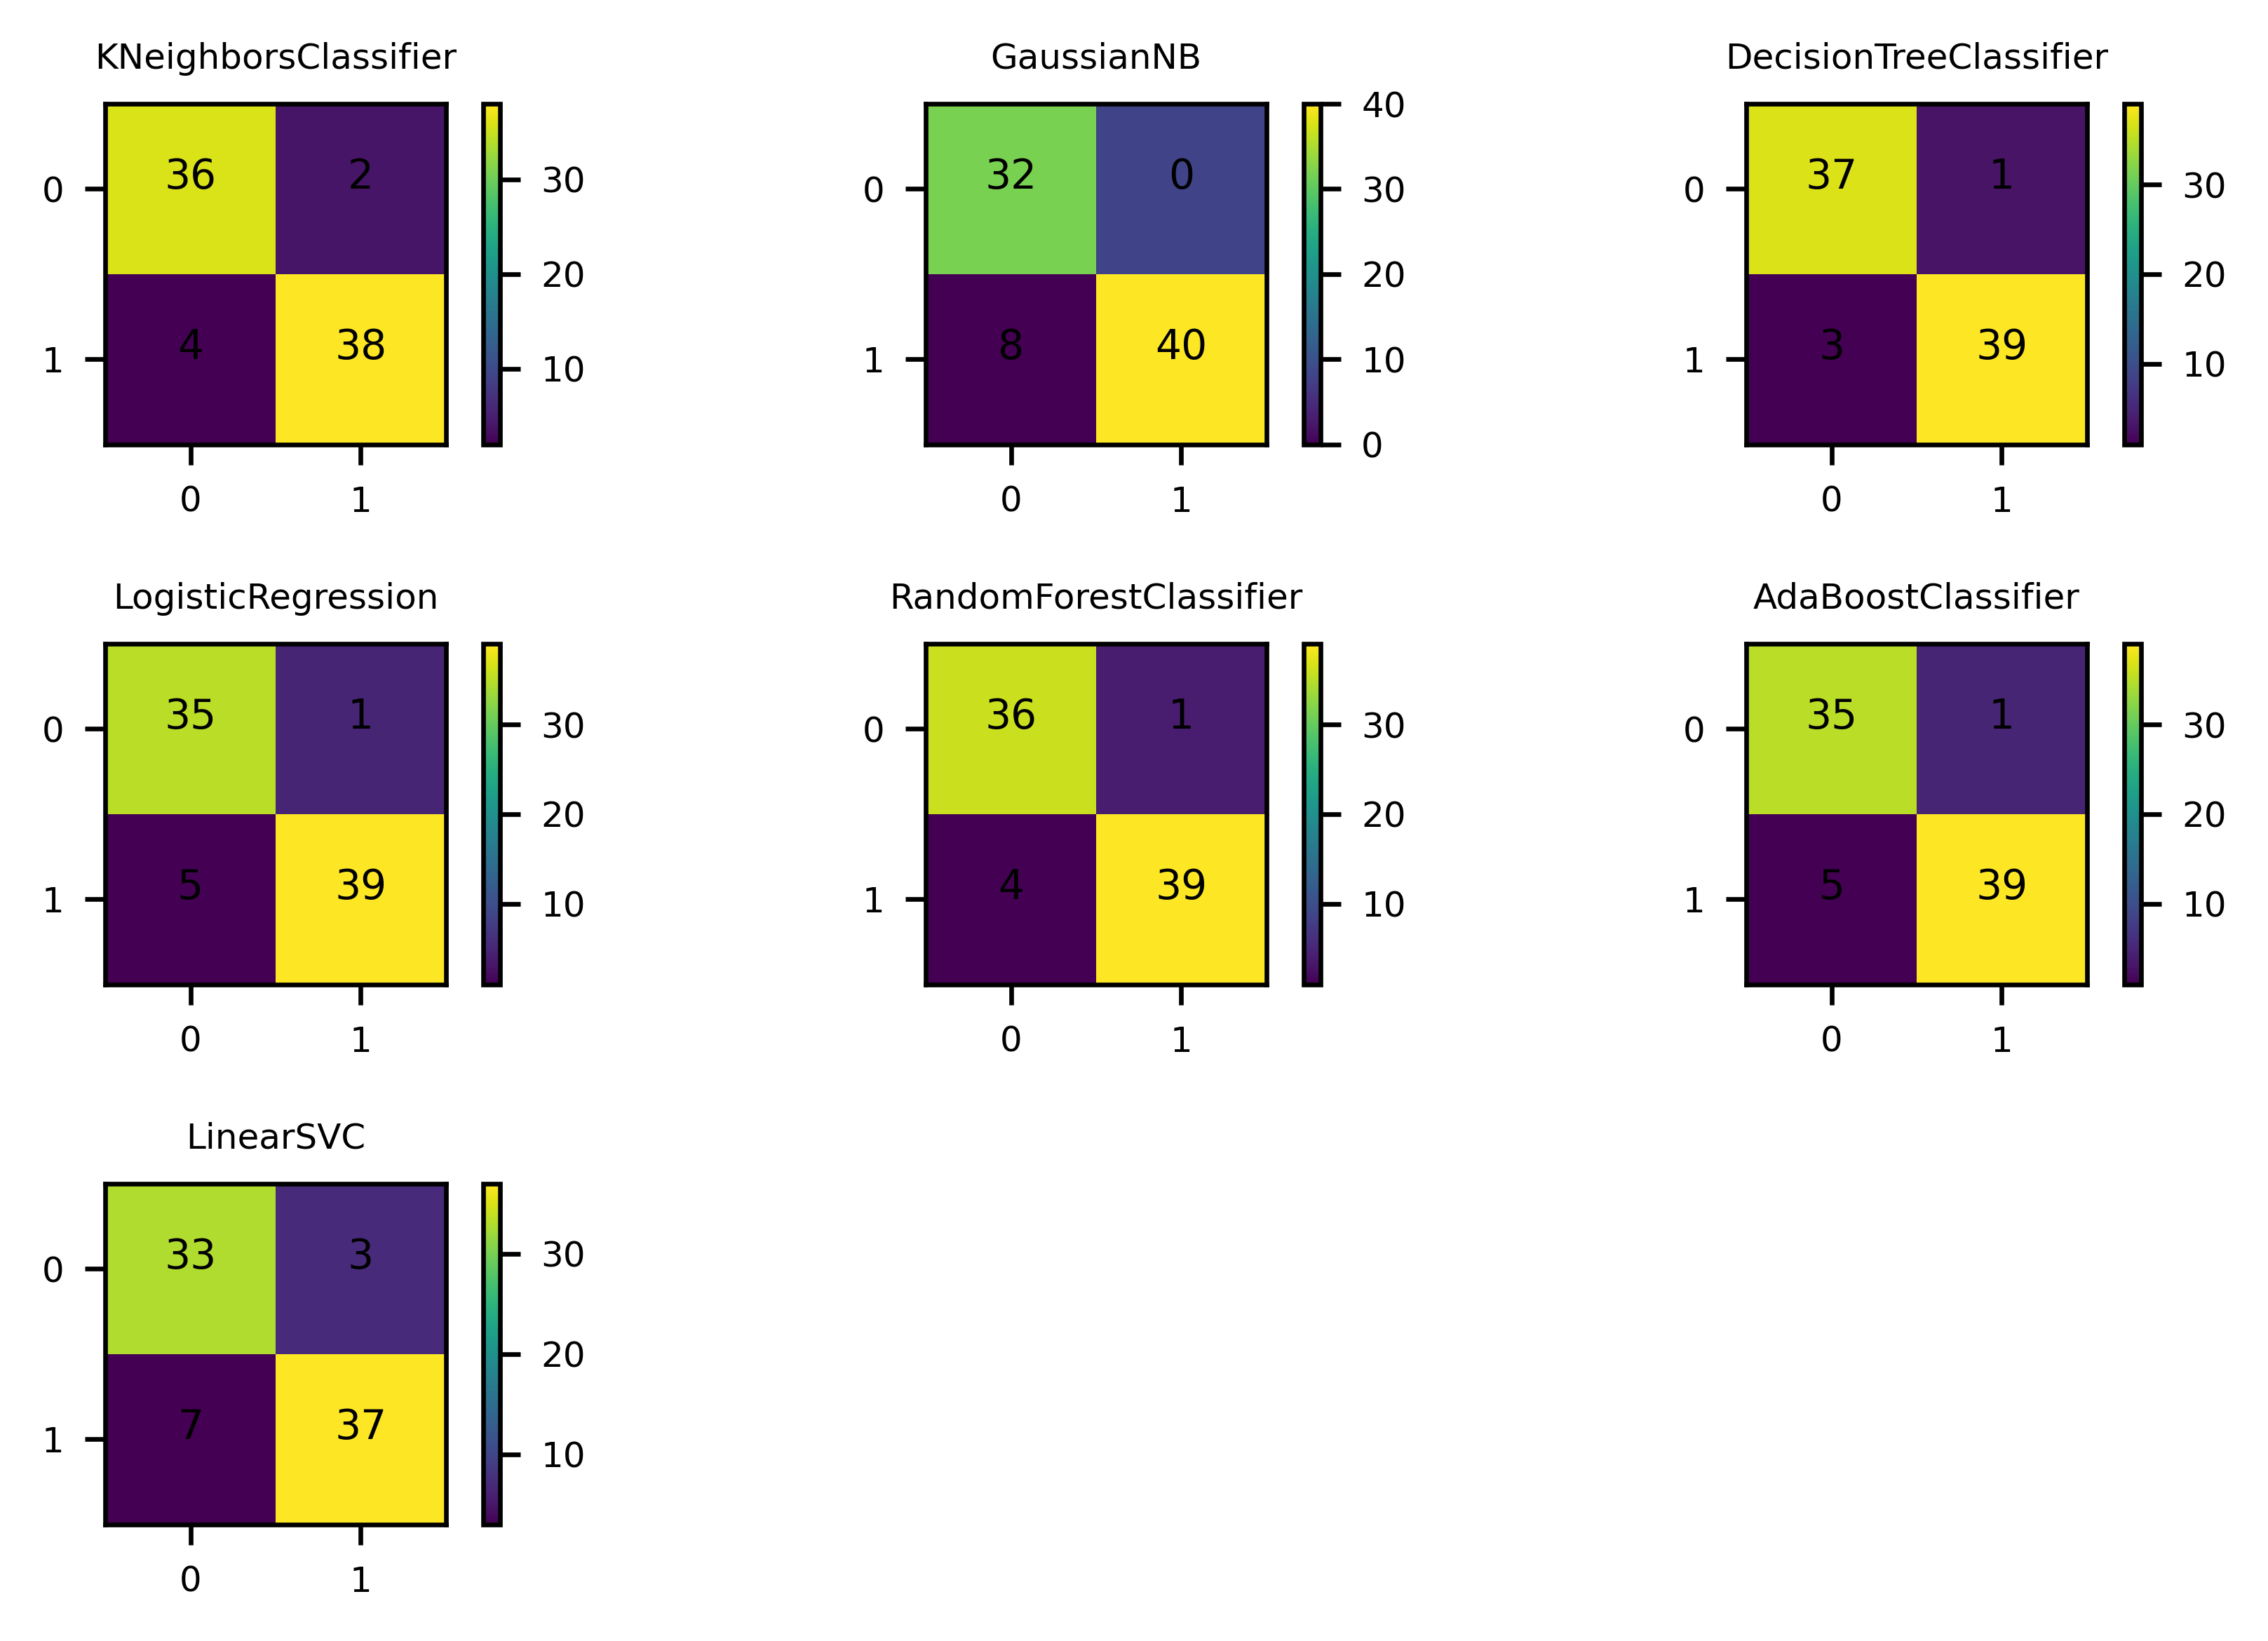

In [15]:
#如何把7各图，设置成3x2的图+1
names=['KNeighborsClassifier','GaussianNB','DecisionTreeClassifier',
       'LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LinearSVC']
fig=plt.figure(dpi=600)
for i in range(len(confusion_matrixs)):
    ax=plt.subplot(3,3,i+1)#subplot是一个图一个图的加上去
    m=ax.imshow(confusion_matrixs[i])
    n=fig.colorbar(m,ax=ax,cmap=plt.cm.Blues)
    n.ax.tick_params(labelsize=6)  #设置色标刻度字体大小。
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    ax.set_title(names[i],fontsize=6)
    for rows in range(confusion_matrixs[i].shape[1]):
        for columns in range(confusion_matrixs[i].shape[0]):
            ax.text(rows,columns,confusion_matrixs[i][rows,columns],
                     horizontalalignment='center',fontsize=7)
plt.tight_layout()
plt.savefig('混沌矩阵',dpi=600)

0为恶行，1为良性：

fpr：<span class="mark">真的是负类，正确分类的概率</span>,假正类的概率,false positive rate

tpr：<span class="mark">真的是正类，正确分类成正类的概率</span>,真正类的概率,true positive rate

thresholds

## 绘制roc_curve

In [16]:
fpr=[]
tpr=[]
for i in roc_score:
    a,b,c=roc_curve(labels_cv,i)
    fpr.append(a)
    tpr.append(b)

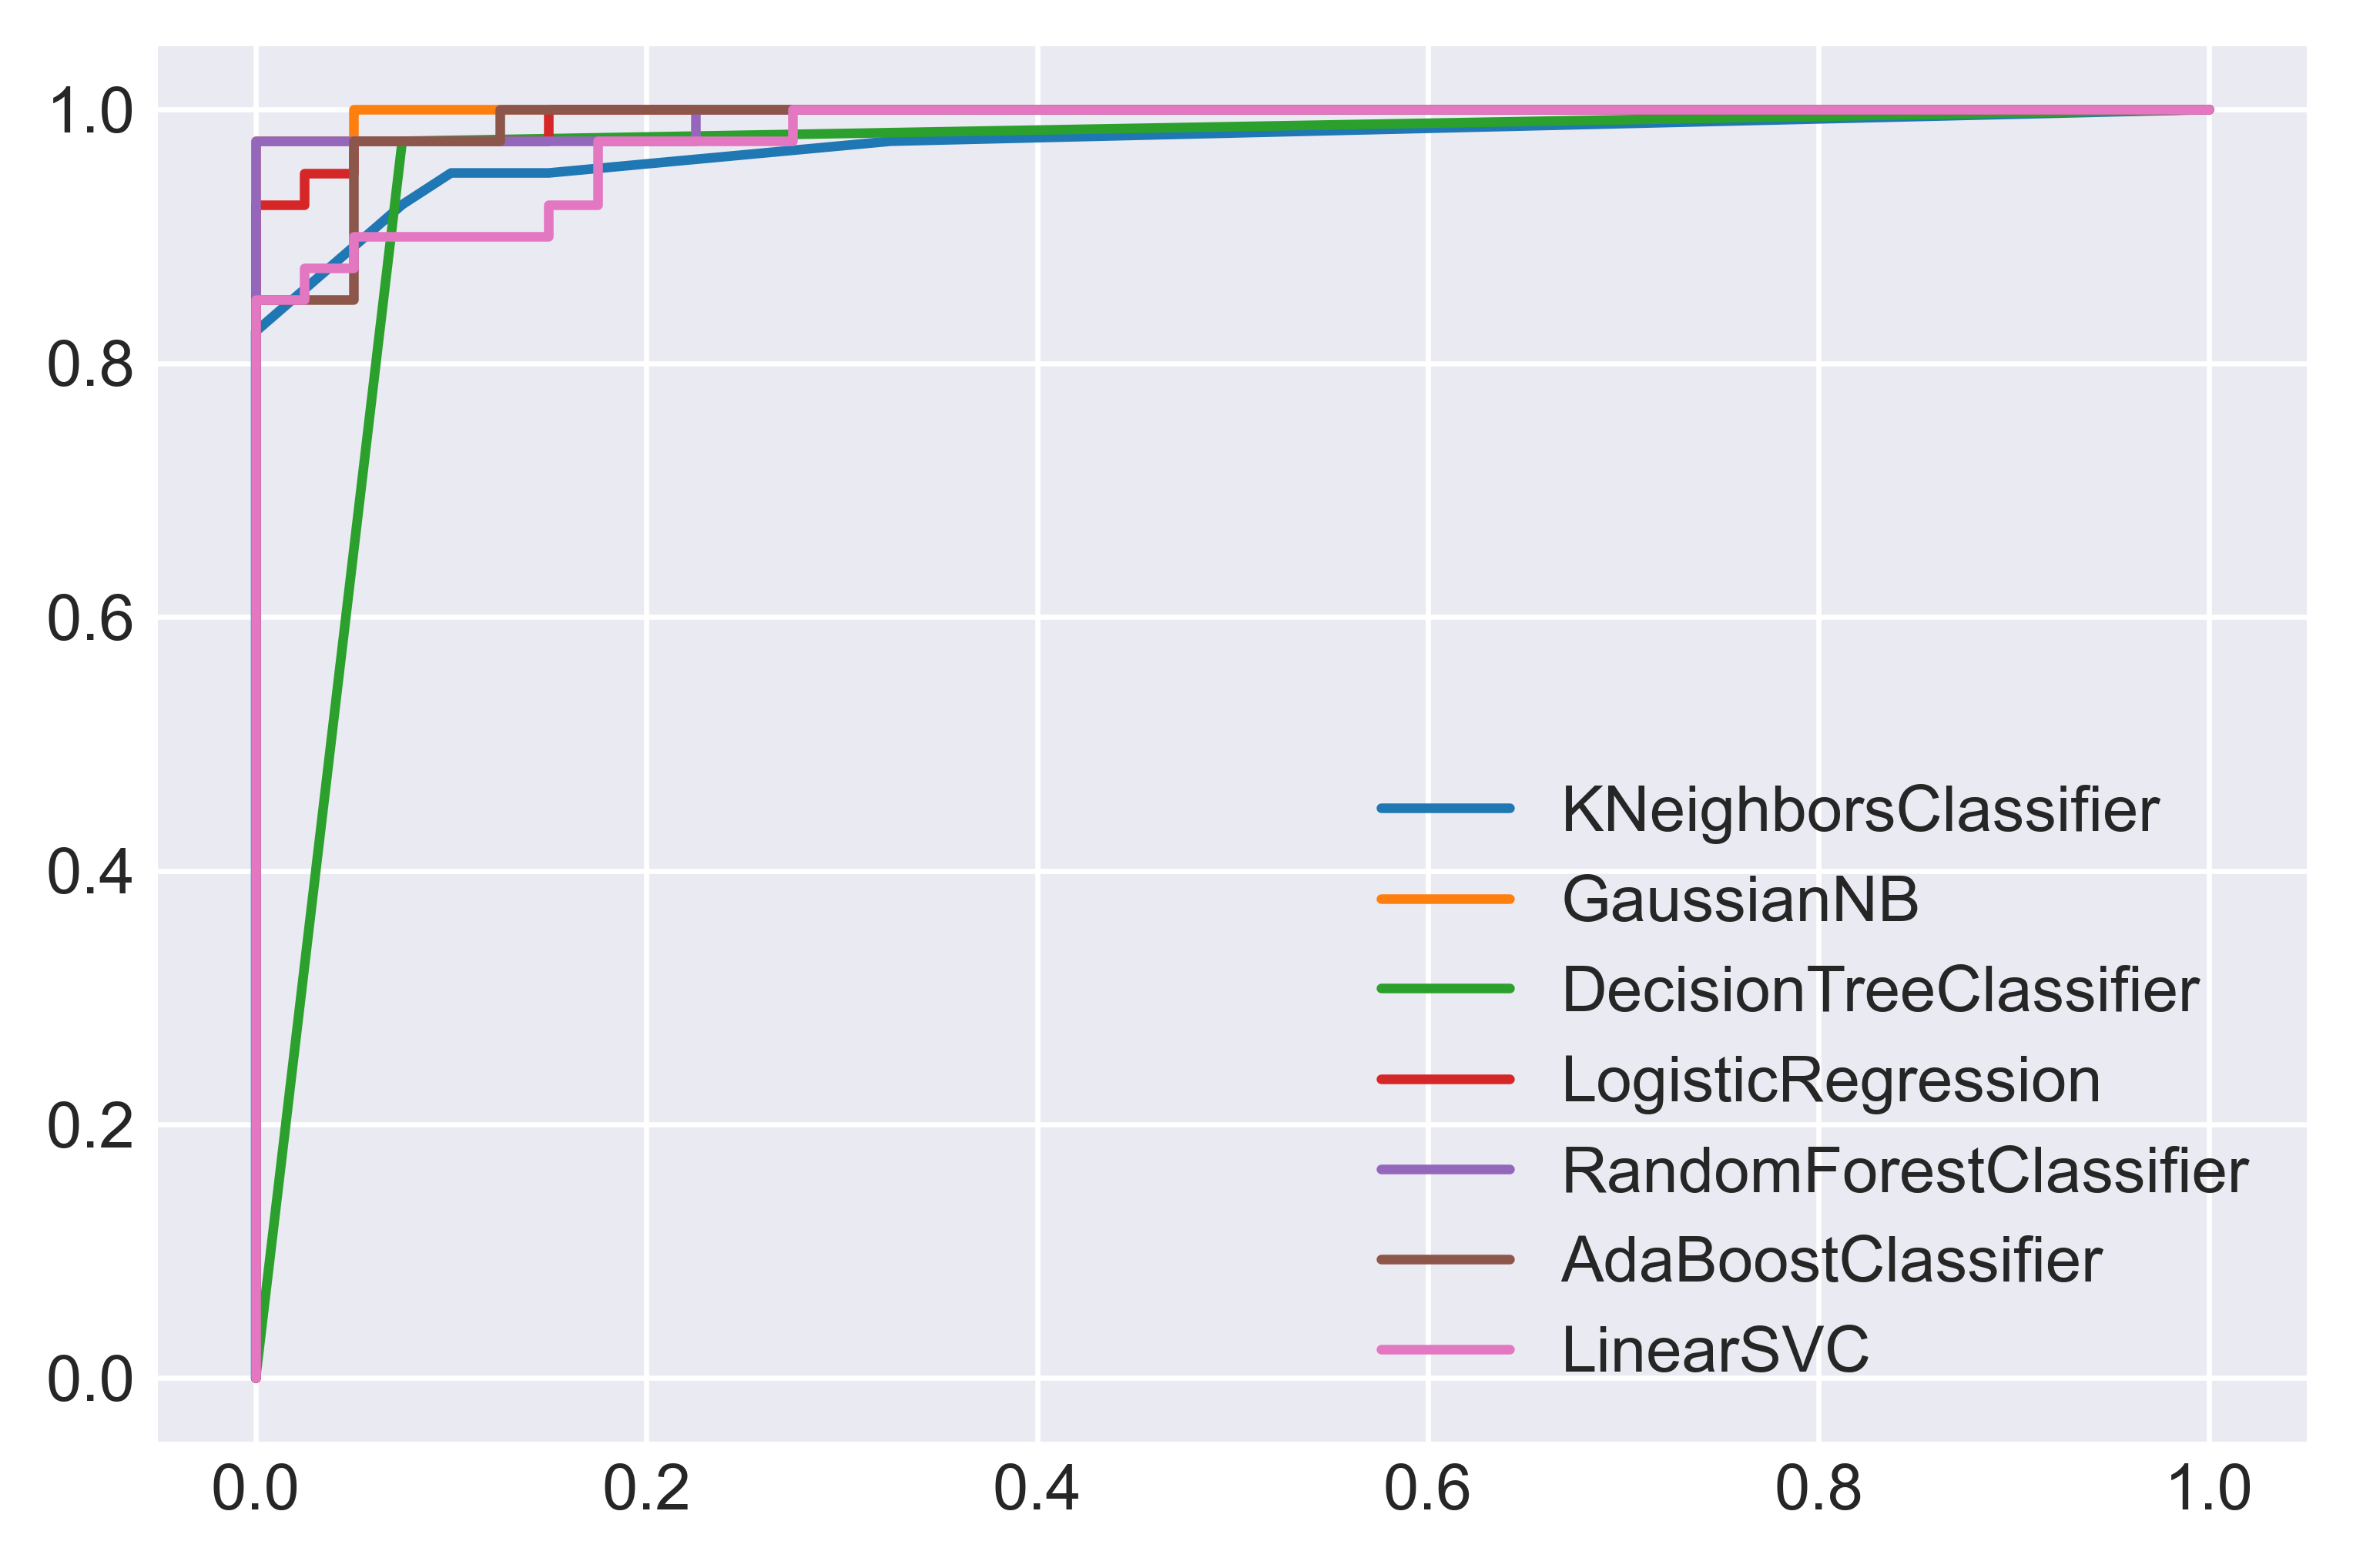

In [17]:
auc_score=[]
labels=['KNeighborsClassifier','GaussianNB','DecisionTreeClassifier',
        'LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LinearSVC']
plt.style.use('seaborn-darkgrid')
plt.figure(dpi=600)
for m,n,label in zip(fpr,tpr,labels):
    plt.plot(m,n,label=label)
    auc_score.app
    end(auc(m,n))
plt.legend()
plt.savefig('roc图',dpi=600)

In [18]:
df2=pd.DataFrame(auc_score,index=labels,columns=['auc-score'])

In [19]:
pd.concat([df1,df2],axis=1)

,准确度,auc-score
KNeighborsClassifier,0.9375,0.963750
GaussianNB,0.9250,0.977500
DecisionTreeClassifier,0.8875,0.887500
LogisticRegression,0.9375,0.996875
RandomForestClassifier,0.9250,0.987187
AdaBoostClassifier,0.9375,0.977500
LinearSVC,0.7875,0.946250


In [32]:
a=['KNeighborsClassifier', 'GaussianNB', 'DecisionTreeClassifier',
       'LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier',
       'LinearSVC']
b=pd.DataFrame({'准确度':[0.8875, 0.925 , 0.925 , 0.9375, 0.9375, 0.9625, 0.8875],'auc-score':[0.9421875, 0.985625 , 0.925    , 0.988125 , 0.9753125, 0.986875 ,0.970625 ],
               },index=['KNeighborsClassifier', 'GaussianNB', 'DecisionTreeClassifier',
       'LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier',
       'LinearSVC'])
b

,准确度,auc-score
KNeighborsClassifier,0.8875,0.942187
GaussianNB,0.9250,0.985625
DecisionTreeClassifier,0.9250,0.925000
LogisticRegression,0.9375,0.988125
RandomForestClassifier,0.9375,0.975313
AdaBoostClassifier,0.9625,0.986875
LinearSVC,0.8875,0.970625


In [ ]:
                           准确度  auc-score
KNeighborsClassifier    0.8875   0.942187
GaussianNB              0.9250   0.985625
DecisionTreeClassifier  0.9250   0.925000
LogisticRegression      0.9375   0.988125
RandomForestClassifier  0.9375   0.975313
AdaBoostClassifier      0.9625   0.986875
LinearSVC               0.8875   0.970625